In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

Making spectrum colormap

In [2]:
colour_list = ["#c8274c","#f25546","#F06543","#e96e33","#f0b038","#FFE74C",
               "#69b944","#72b286","#69b0bc","#619ee4","#4b5bbb"][::-1]
from matplotlib.colors import LinearSegmentedColormap
cmap_iam = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)
cmap_iam.set_bad('wheat')

Class used to move the zero point of diverging colormaps

In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

## Loading salinity, depth, and mask variables

In [4]:
def get_vars(dirname):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU:
        deptht = dsT.variables['deptht'][:]
        vosaline0 = dsT.variables['vosaline'][:, :, y, x]
        sozotaux = dsU.variables['sozotaux'][:,0,0] 
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, :, y, x]
        
    tmask = np.tile(tmask0, (len(sozotaux), 1, 1, 1))  
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vosaline, sozotaux, deptht, tmask

In [5]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_base_flt/'
vosaline, sozotaux, deptht, tmask = get_vars(dirname)

In [6]:
vosaline_ref_1 = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_base_flt/1_salinity_for_agrif.nc')['vosaline'][:]

In [7]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]

In [8]:
vosaline.shape, vosaline_ref_1.shape, vosaline_ref.shape

((480, 80, 272, 242), (1, 80, 274, 244), (1, 80, 190, 255))

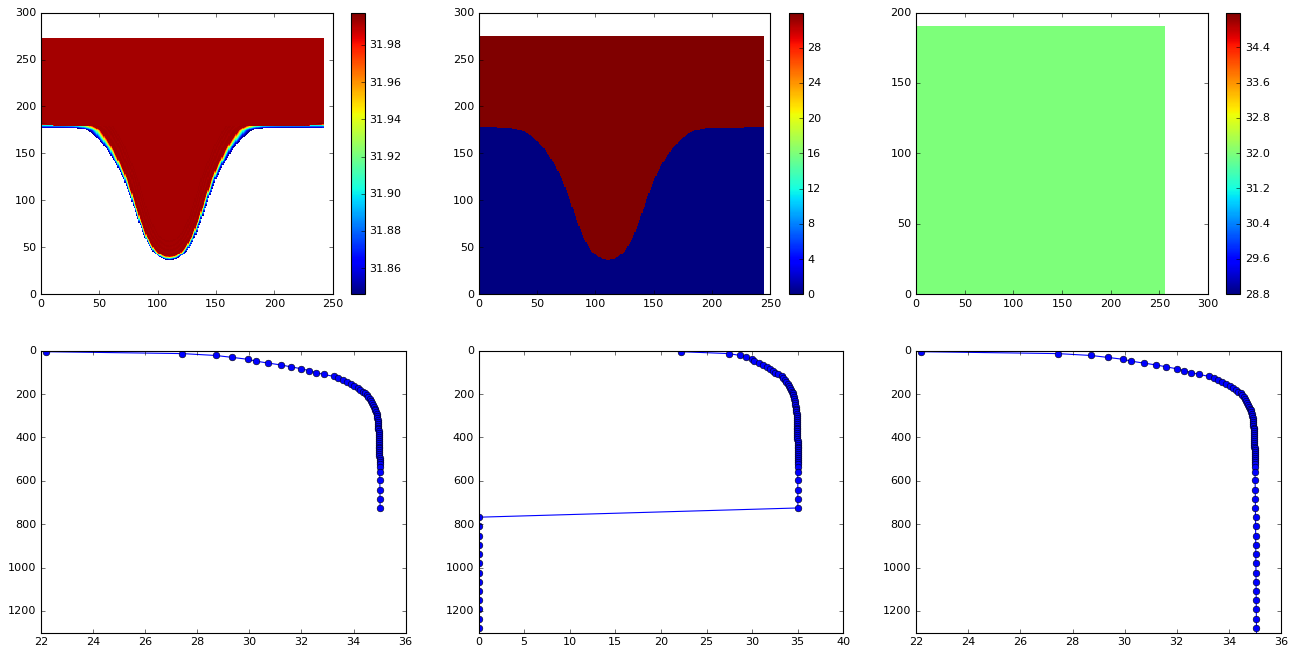

In [9]:
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(20, 10))
p1 = ax1.pcolormesh(vosaline[0, 9, :, :])
p2 = ax2.pcolormesh(vosaline_ref_1[0, 9, :, :])
p3 = ax3.pcolormesh(vosaline_ref[0, 9, :, :])

for ax, p in zip ([ax1, ax2, ax3], [p1, p2, p3]):
    fig.colorbar(p, ax=ax)

ax4.plot(vosaline[0, :, 200, 100], deptht, marker='o')
ax5.plot(vosaline_ref_1[0, :, 200, 100], deptht, marker='o')
ax6.plot(vosaline_ref[0, :, 0, 0], deptht, marker='o')

for ax, p in zip ([ax4, ax5, ax6], np.arange(3)):
    ax.set_ylim([1300, 0])

## Reference salinity profile

In [10]:
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

## Daily averages of salinity results

In [11]:
dep_ind = 9
y_ind = 200
vosaline_canyon = vosaline[:, dep_ind, :, :]

In [12]:
def get_1day_avg(sal, day_start, day_end):
    day = slice(day_start*24, day_end*24, None)
    sal_day = np.mean(sal[day, ...], axis=0)
    return sal_day

In [13]:
vosaline_canyon_daily = np.full((vosaline_canyon.shape[-3]/24, vosaline_canyon.shape[-2], vosaline_canyon.shape[-1]), np.nan)

In [14]:
for i in range(vosaline_canyon_daily.shape[0]):
    day_start, day_end = i, i+1
    vosaline_canyon_daily[i, :, :] = get_1day_avg(vosaline_canyon, day_start, day_end)

## Original depths in indices and metres of salinity results

In [15]:
deptht_i_canyon_daily = np.full_like(vosaline_canyon_daily, np.nan, dtype=np.int)

In [16]:
# this loop traces where "this_vosaline" occured in the initial salinity profile and returns the depth index of this
# original depth

for t in range(deptht_i_canyon_daily.shape[-3]):
    if t == 5 or t ==15:
        print(str(t))
    for y in range(deptht_i_canyon_daily.shape[-2]):
        for x in range(deptht_i_canyon_daily.shape[-1]):
            this_vosaline = vosaline_canyon_daily[t, y, x]
            deptht_i_canyon_daily[t, y, x] = min(range(len(vosaline_ref_profile)), key=lambda i: abs(vosaline_ref_profile[i]-this_vosaline))

5
15


In [17]:
tmask_for_deptht = np.tile(tmask[0, dep_ind, :, :], (deptht_i_canyon_daily.shape[0], 1, 1))

In [18]:
deptht_i_canyon_daily = np.ma.array(deptht_i_canyon_daily, mask=1 - tmask_for_deptht)

In [19]:
deptht_m_canyon_daily = deptht[deptht_i_canyon_daily]

deptht_m_canyon_daily = np.ma.array(deptht_m_canyon_daily, mask=1 - tmask_for_deptht)

In [20]:
deptht_change_canyon_daily = deptht_m_canyon_daily - deptht[dep_ind]

## Making figures for original depths of salinities

In [21]:
def pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel):
    
    fig, axes = plt.subplots(3, 4, figsize = (20, 20))
    for ax, n in zip(axes.flatten(), np.arange(12)):  
        p = ax.pcolormesh(plot_array[n, :, :], cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_aspect(aspect='equal')
        ax.set_xlim([0, plot_array.shape[-1]])
        ax.set_ylim([0, plot_array.shape[-2]])
        ax.set_title('Day ' + str(n+1), fontsize=20)
        if n == 0:
            cbar = fig.colorbar(p, ax=ax, fraction=0.05, orientation='horizontal', pad=0.009)
            cbar.set_label(cblabel, fontsize=18, rotation=0, labelpad=2.5)
            cbar.ax.tick_params(labelsize=13)
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
        else:
            pass
    fig.tight_layout(w_pad=1.2, h_pad=0.01)
    fig.suptitle(title + ' [Depth = '+str(int(deptht[dep_ind]))+' m]', fontsize=25)
    plt.subplots_adjust(top=0.95)

    return fig

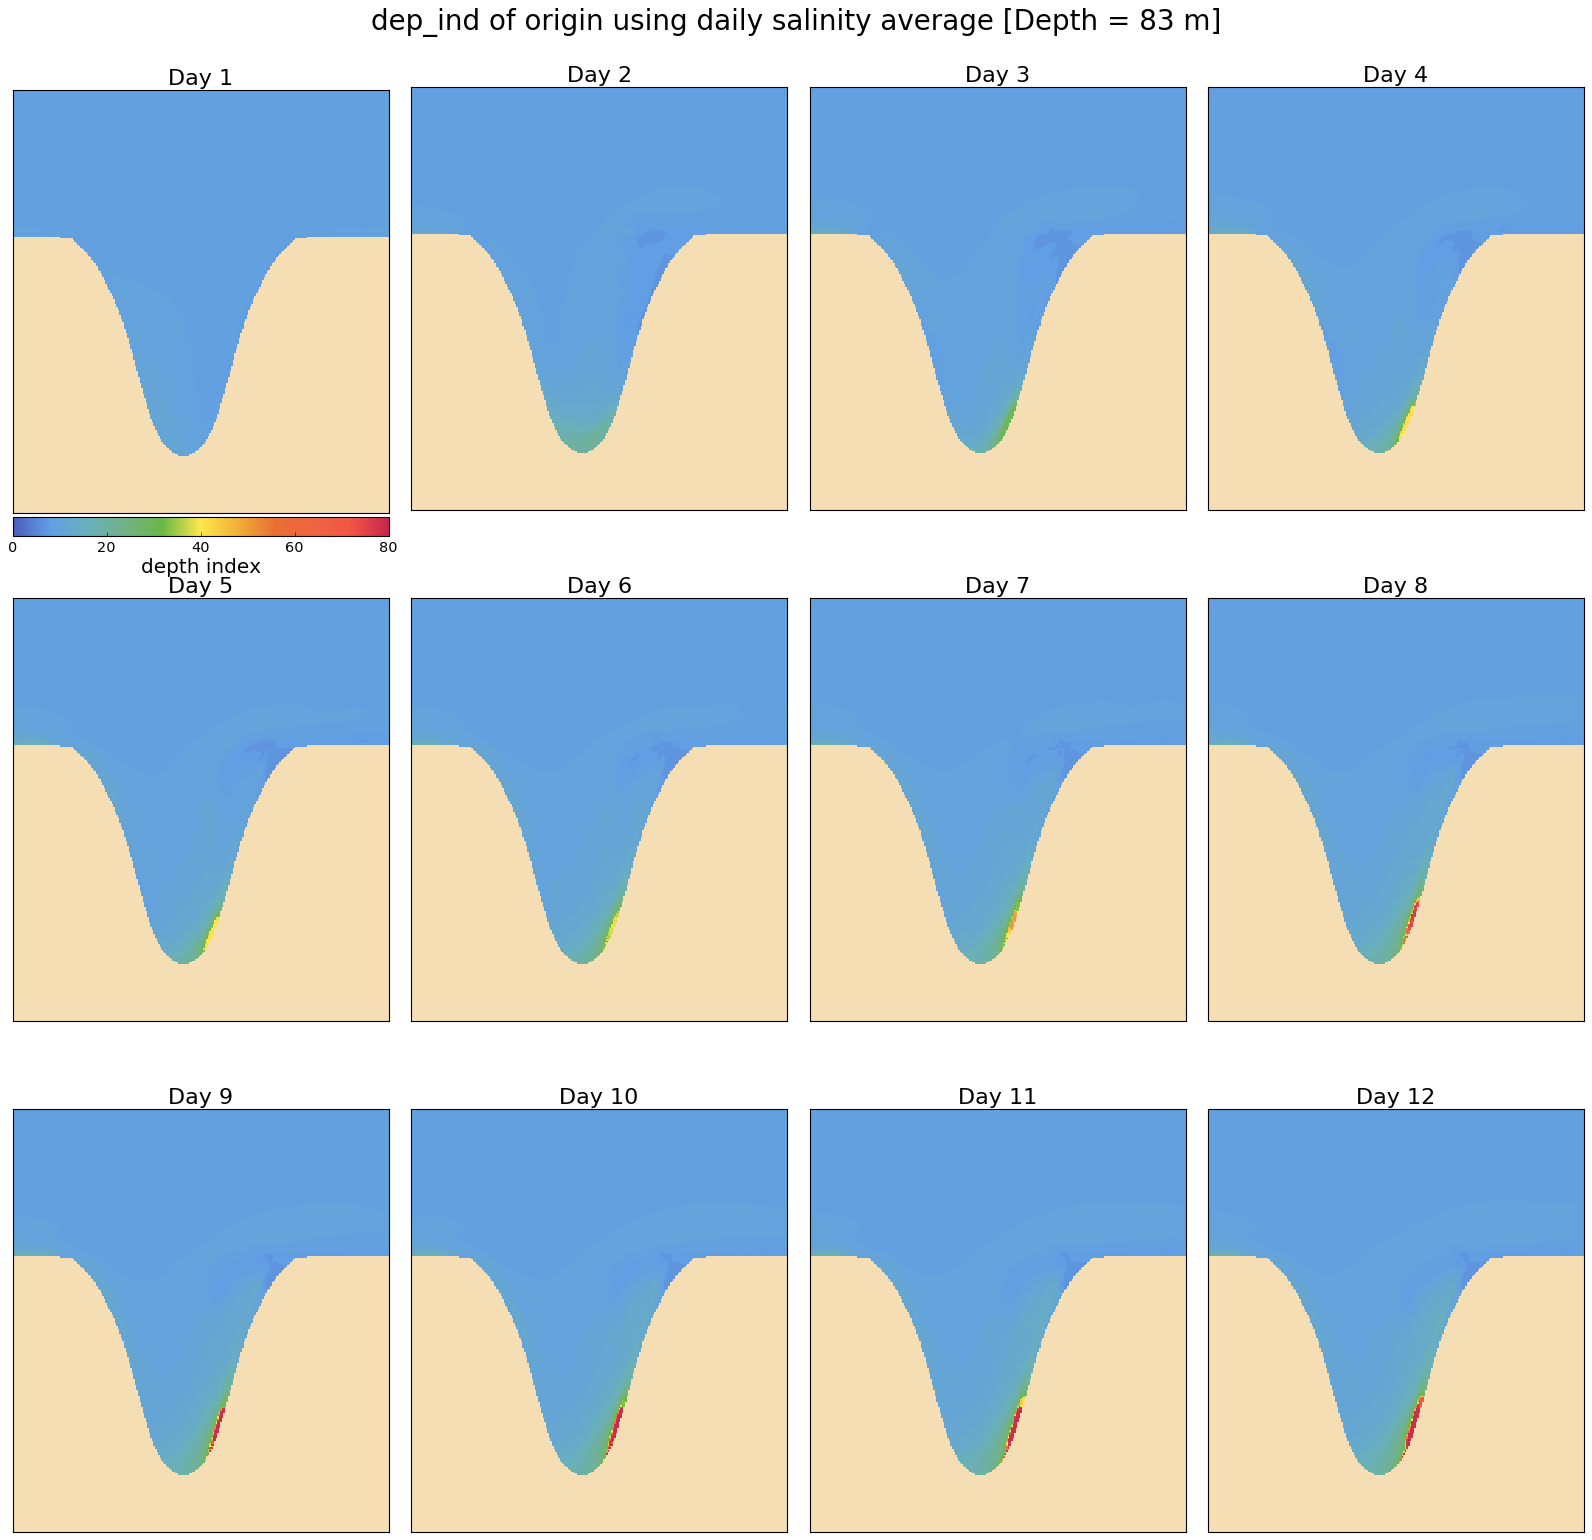

In [22]:
plot_array = deptht_i_canyon_daily
cmap, norm = cmap_iam, None
vmin, vmax = 0, 80
title, cblabel = 'dep_ind of origin using daily salinity average', 'depth index'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

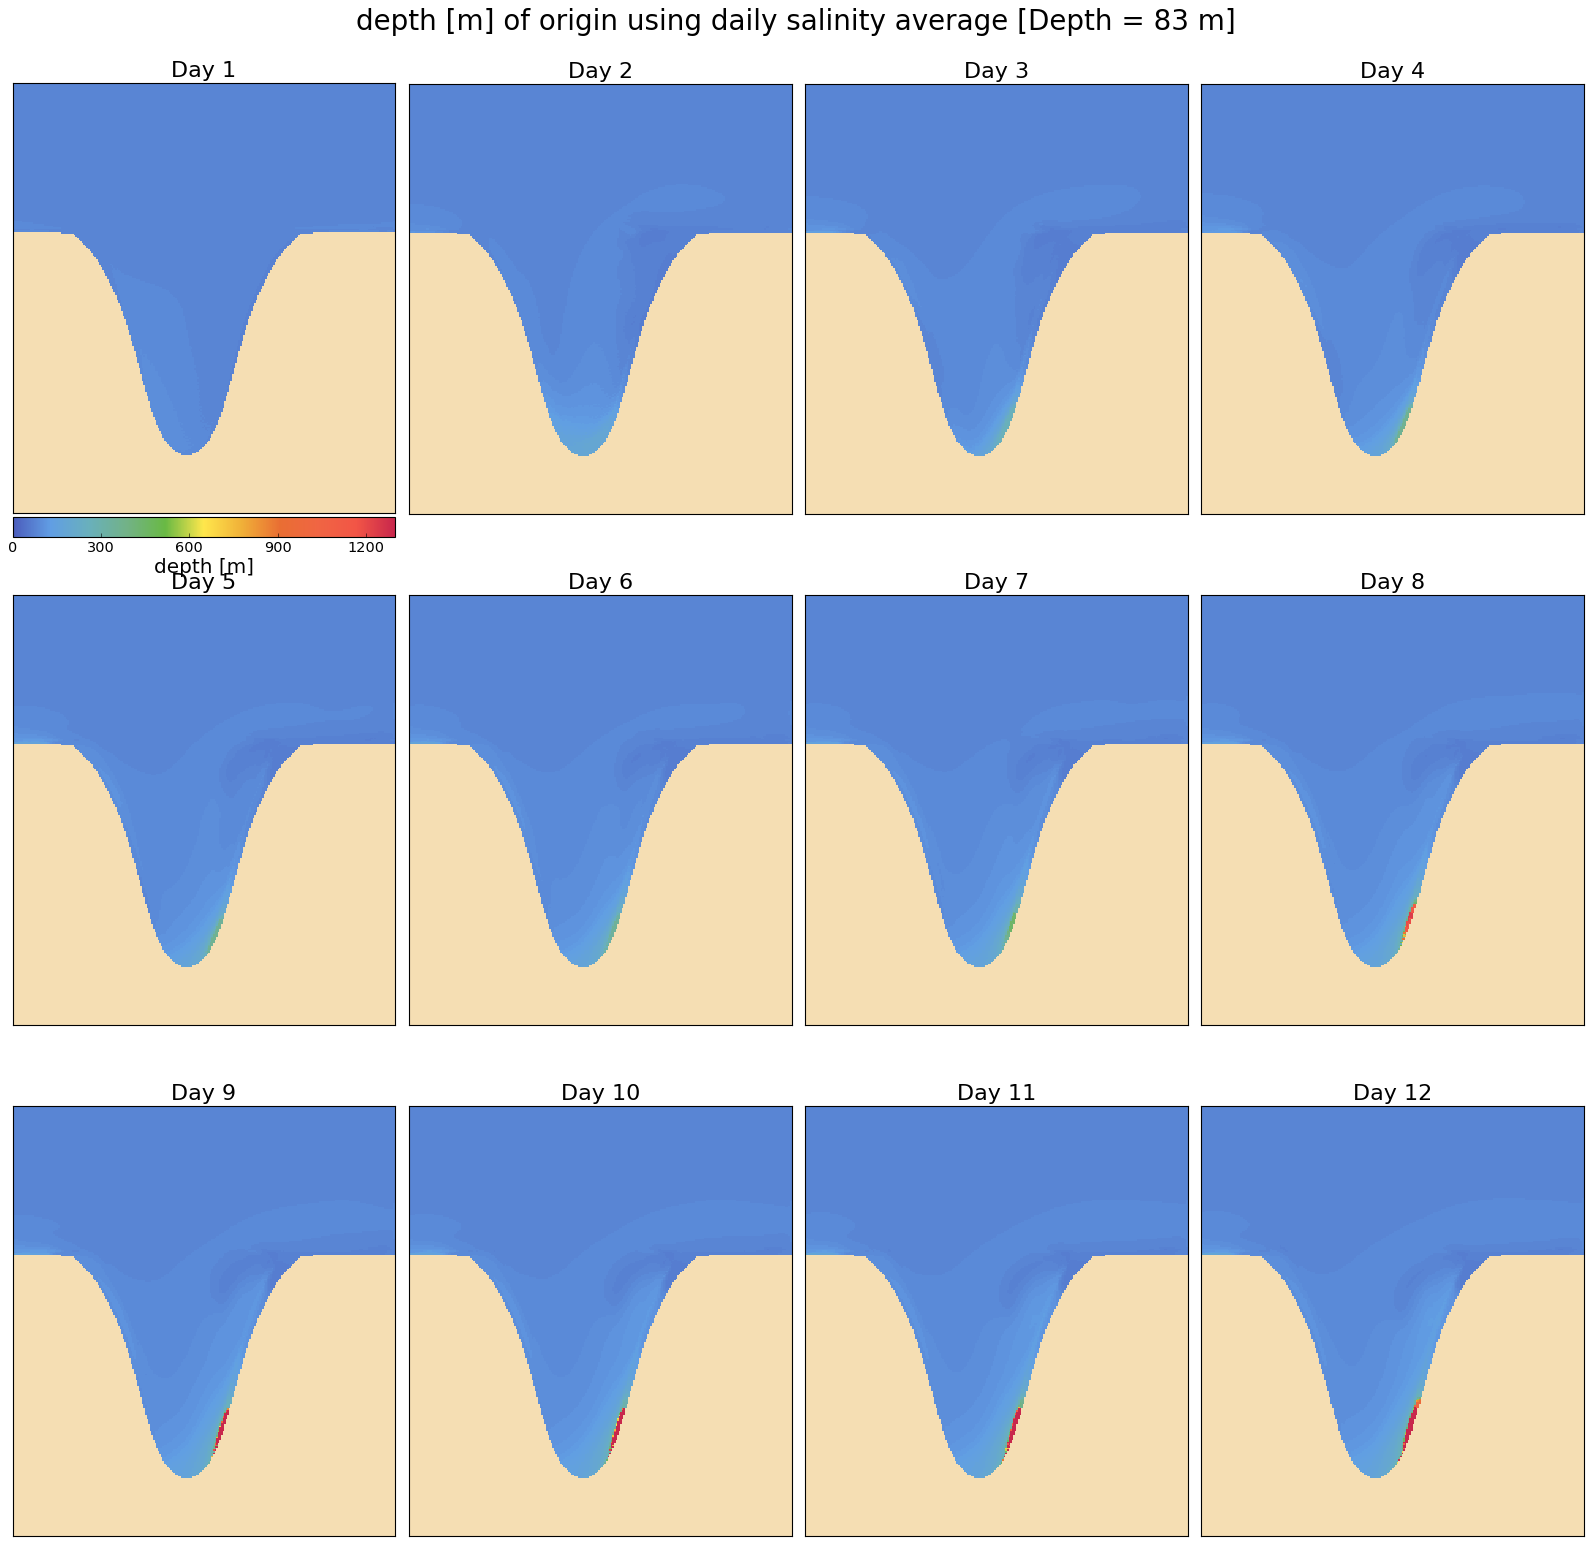

In [23]:
plot_array = deptht_m_canyon_daily
cmap, norm = cmap_iam, None
vmin, vmax = 0, 1300
title, cblabel = 'depth [m] of origin using daily salinity average', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

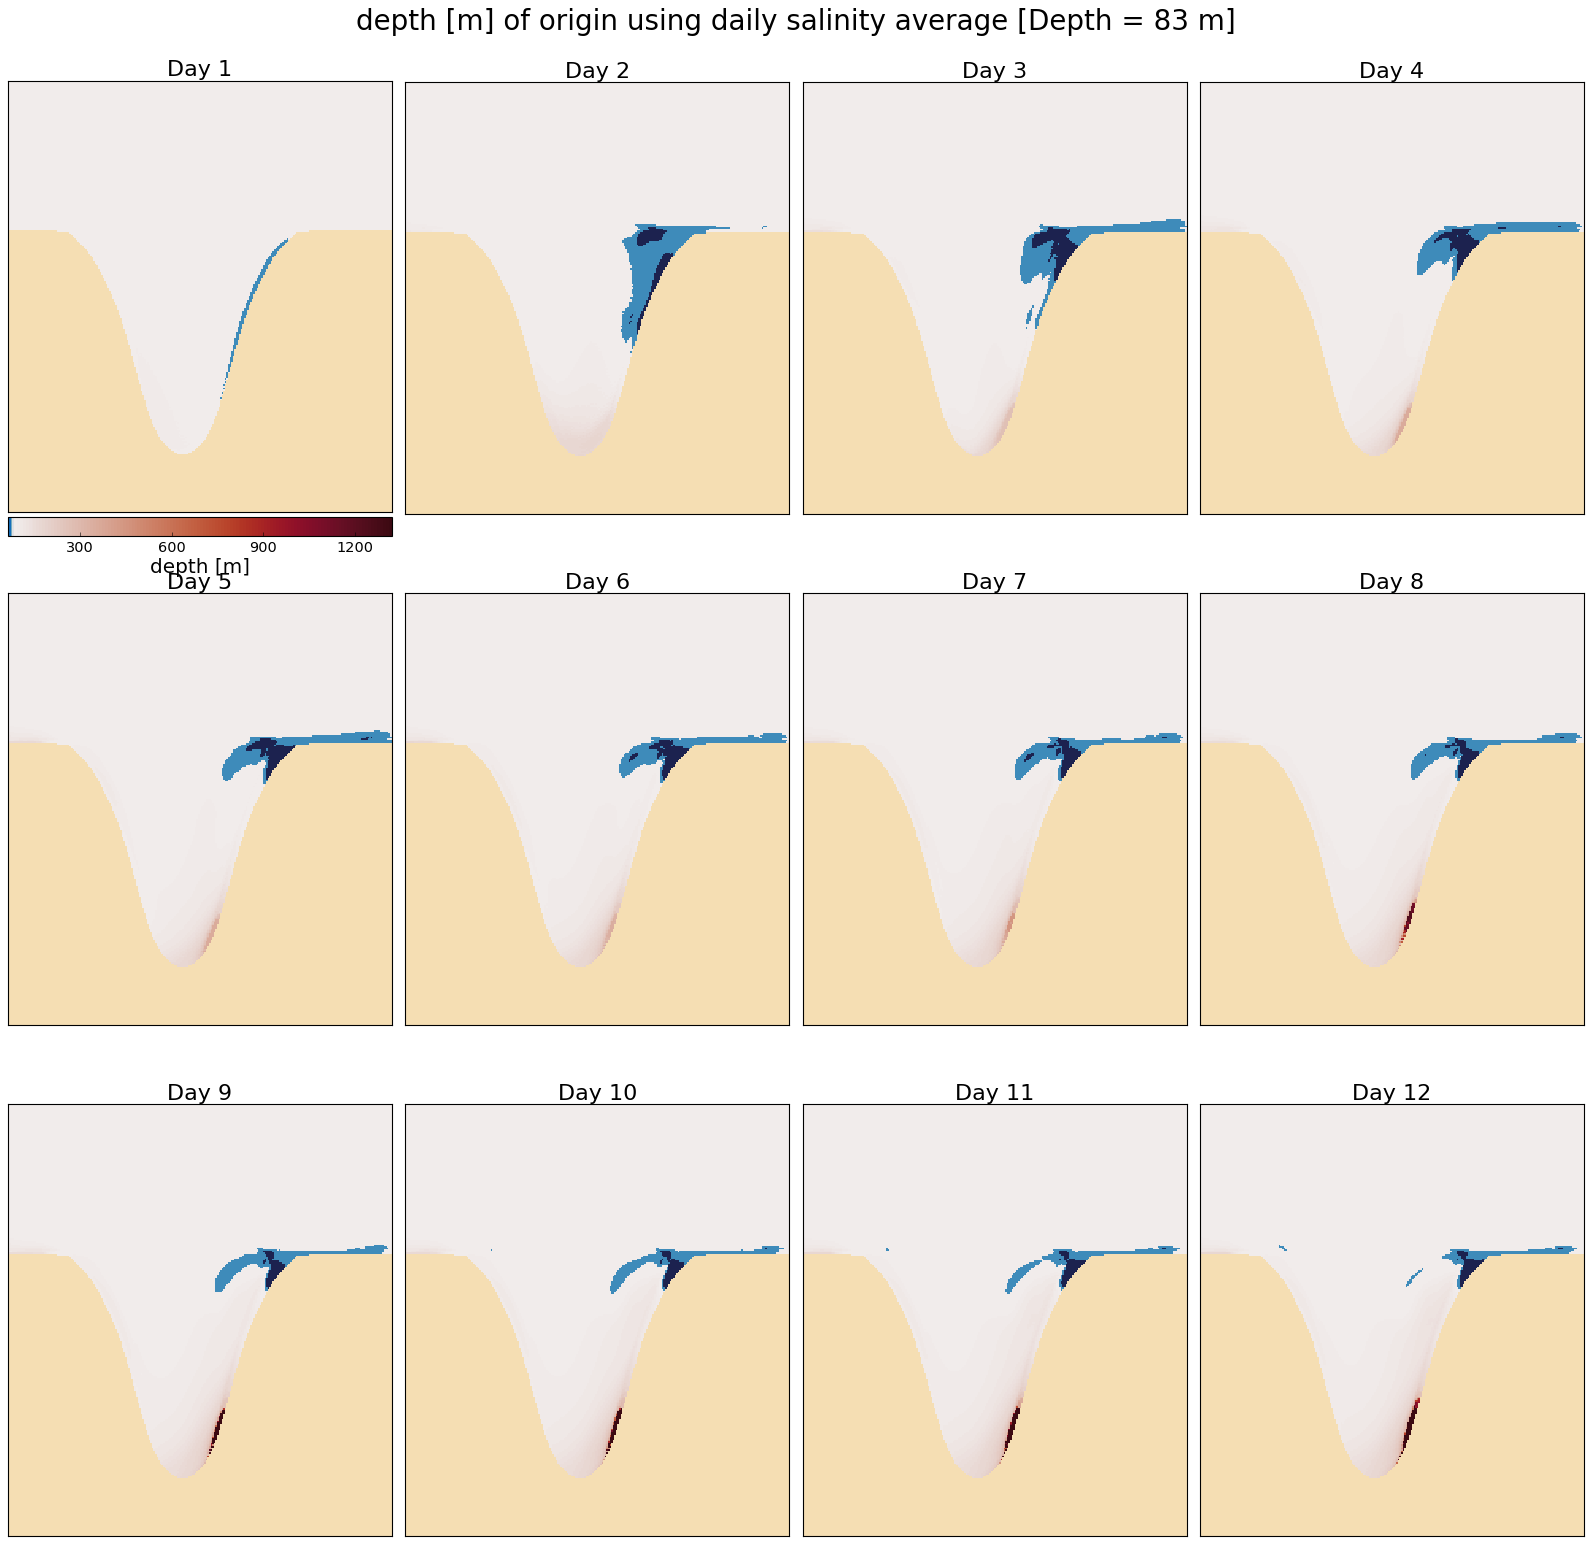

In [24]:
plot_array = deptht_m_canyon_daily
cmap, norm = cmo.cm.balance, MidpointNormalize(midpoint=deptht[dep_ind])
cmap.set_bad('wheat')
vmin, vmax = int(np.min(deptht_m_canyon_daily)), int(np.max(deptht_m_canyon_daily))
title, cblabel = 'depth [m] of origin using daily salinity average', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

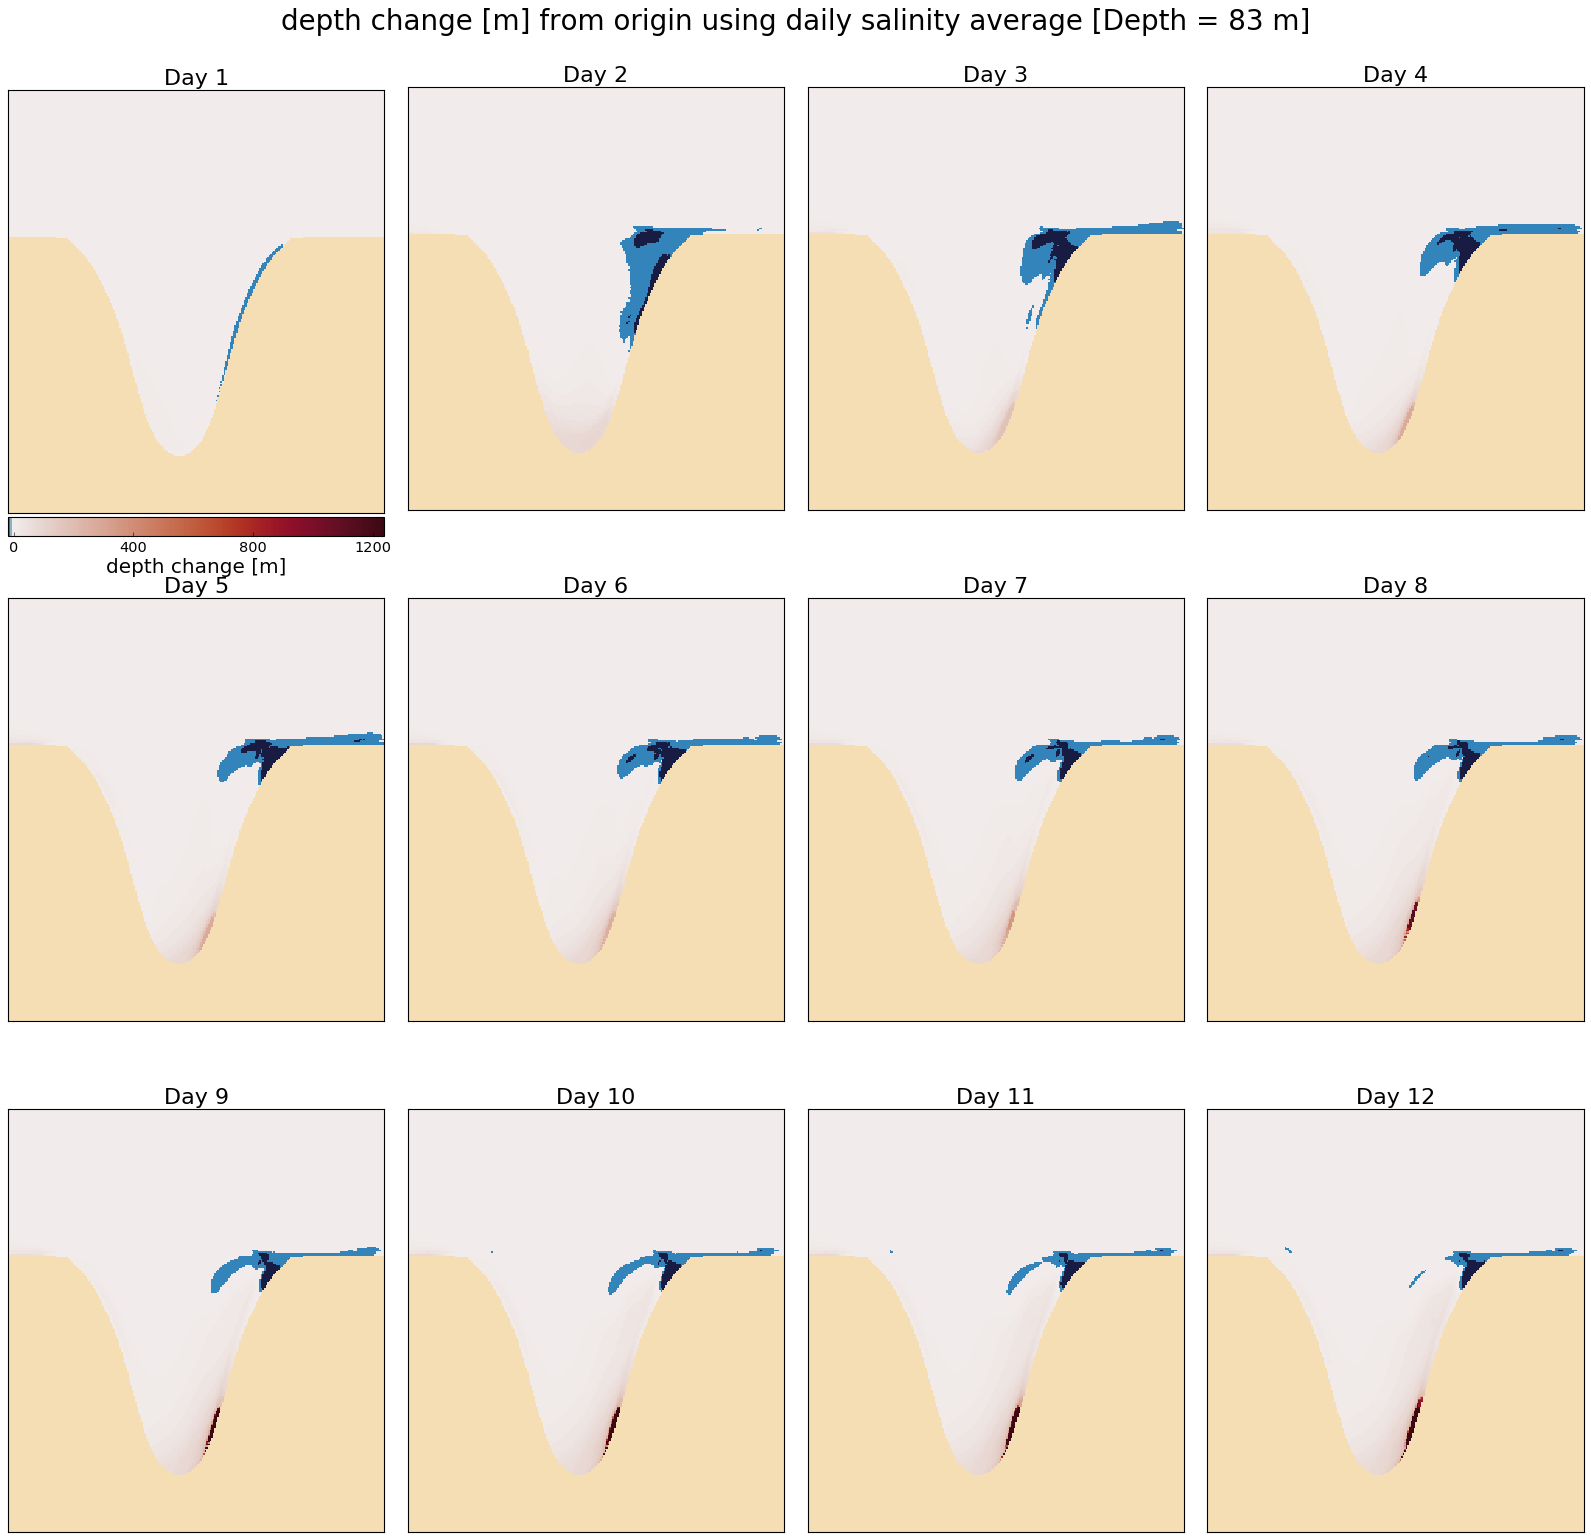

In [25]:
plot_array = deptht_change_canyon_daily
cmap, norm = cmo.cm.balance, MidpointNormalize(midpoint=0)
cmap.set_bad('wheat')
vmin, vmax = int(np.min(deptht_change_canyon_daily)), int(np.max(deptht_change_canyon_daily))
title, cblabel = 'depth change [m] from origin using daily salinity average', 'depth change [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

## Time series

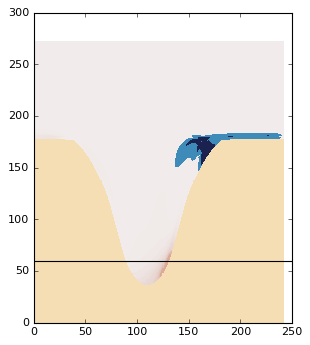

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cmap = cmo.cm.balance
cmap.set_bad('wheat')
vmin, vmax = int(np.min(deptht_m_canyon_daily)), int(np.max(deptht_m_canyon_daily))
ax.pcolormesh(deptht_m_canyon_daily[3], cmap=cmap, vmin=vmin, vmax=vmax, norm=MidpointNormalize(midpoint=deptht[dep_ind]))
ax.set_aspect(aspect='equal')
ax.axhline(60, c='k')
#ax.axhline(170, c='k')

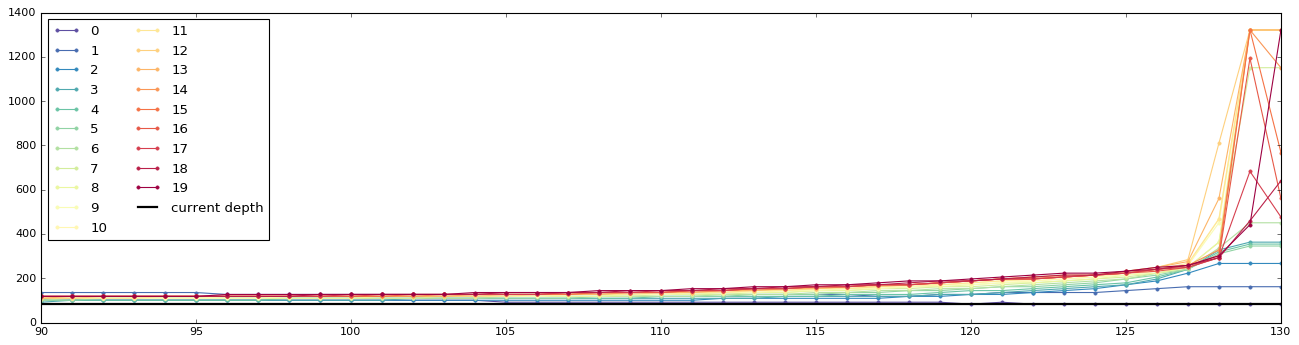

In [27]:
y_cross = 60
xs = np.arange(deptht_m_canyon_daily.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
cm_times = np.linspace(0, 1, deptht_m_canyon_daily.shape[-3])
colors = [cm.Spectral_r(x) for x in cm_times]

for t in range(20):
    plot_cross = deptht_m_canyon_daily[t, y_cross, :]
    ax.plot(xs, plot_cross, marker='.', c=colors[t], lw=1, label=str(t))
ax.axhline(deptht[dep_ind], c='k', lw=2, label='current depth')
ax.legend(ncol=2, loc=2)

In [28]:
from matplotlib import pyplot as plt
from matplotlib import style

# use ggplot style sheet
style.use('ggplot')

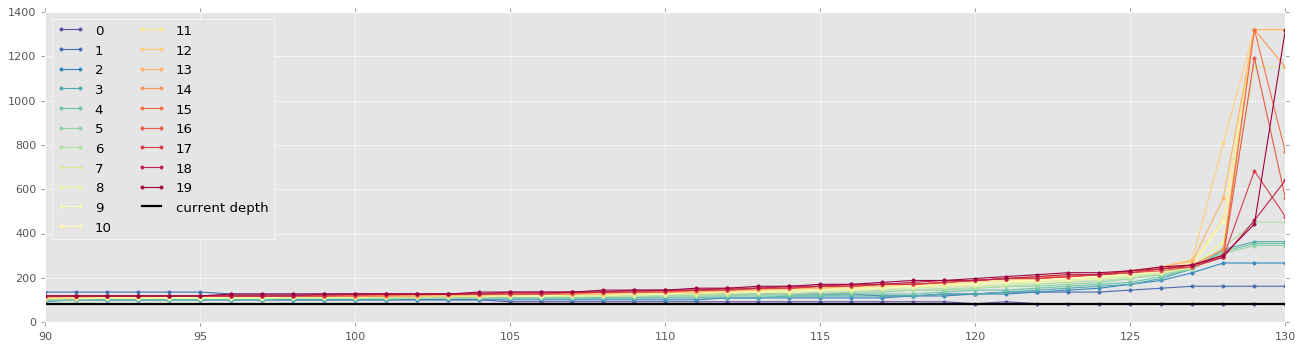

In [29]:
y_cross = 60
xs = np.arange(deptht_m_canyon_daily.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
cm_times = np.linspace(0, 1, deptht_m_canyon_daily.shape[-3])
colors = [cm.Spectral_r(x) for x in cm_times]

for t in range(20):
    plot_cross = deptht_m_canyon_daily[t, y_cross, :]
    ax.plot(xs, plot_cross, marker='.', c=colors[t], lw=1, label=str(t))
ax.axhline(deptht[dep_ind], c='k', lw=2, label='current depth')
ax.legend(ncol=2, loc=2)

In [30]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.models import Span

In [31]:
import matplotlib as mpl
colors = ["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.Spectral(mpl.colors.Normalize()(np.arange(20)))]

In [32]:
output_notebook()
p1 = figure()
for t in range(20):
    #p1.circle(xs, deptht_m_canyon_daily[t, y_cross, :], color='black')
    p1.line(xs, deptht_m_canyon_daily[t, y_cross, :], line_color=colors[t], line_width=1.5, legend=str(t))
p1.xaxis.axis_label = 'x index (child)'
p1.yaxis.axis_label = 'depth of origin'
p1.ygrid.band_fill_color = "olive"
p1.ygrid.band_fill_alpha = 0.1
p1.legend.location = "top_left"
show(p1)

Loading BokehJS ...